In [73]:
# Demonstration of Spatial Boostrap 
# Contact: Michael Pyrcz, University of Texas at Austin, Geostatistics Course
#
# Steps:
# 1. Build an initial sample set with $ndata$ samples.  Specify locations.  Sort the data in a data only array for 
#    an equal weighted cumulative density function (CDF) for backtransform
# 2. Calculate the covariance matrix (between the data) for LU simulation.  This provides a fast and easy method
#    to calculate spaitally correlated, unconditional, Gaussian realizations at the data locations.
# 3. Perform LU (lower upper) decomposition of the covariance matrix.  Realizations only require L x random vector.
# 4. Draw from this initial sample set, with replacement, $ndata$ times to build a new realization of the sample.  
#    Repeat this $nreal$ times to make realizations of the sample.  Use LU simulation to ensure spaital correlation 
#    between samples.  Backtransform from Gaussian to original data values (use percentiles to sample).
# 5. Calculate the statistic of interest for each realization. This demonstration considers the mean only.  
#    We could have considered any statistic including median, 13th percentile, skew etc. 
# 6. - 7. Quantify and visualize uncertainty with histograms and summary statistics.
#
# References:
#
# Efron, 1982, The jackknife, the bootstrap, and other resampling plans, Society of Industrial and Applied Math, 
# CBMS-NSF Monographs, 38.
#
# Journel, A. G. Resampling from stochastic simulations. Environmental and Ecological Statistics, 1:63–84, 1994.
#

In [139]:
# Imports 
import pprint
import math
import scipy
import scipy.linalg                # SciPy Linear Algebra Library
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
# 1. Make Spatial Dataset and Define Number of Realizations (just need a sufficient number to summarize uncertainty)
nreal = 100                                               # User Specified
# Assign Data Values - assume 4 data locations
ndata = 4                                                 # User Specified
output = np.zeros((ndata,nreal))  # x, y, value 
data = np.zeros((ndata,3))  # x, y, value 
data[0,0] = 25.0;  data[0,1] = 50.0;  data[0,2] = 2.3     # User Specified
data[1,0] = 75.0;  data[1,1] = 80.0;  data[1,2] = 5.5     # User Specified
data[2,0] = 10.0;  data[2,1] = 25.0;  data[2,2] = 7.0     # User Specified
data[3,0] = 95.0;  data[3,1] = 15.0;  data[3,2] = 8.7     # User Specified
# Set up backtransform lookup table
value = np.zeros(ndata) 
for i in range(0, ndata):
    value[i] = data[i,2]
print(data) 
value.sort()
print(value)

[[ 25.   50.    2.3]
 [ 75.   80.    5.5]
 [ 10.   25.    7. ]
 [ 95.   15.    8.7]]
[ 2.3  5.5  7.   8.7]


In [141]:
# 2. Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified, var_range
cov = np.zeros((ndata,ndata))
var_range = 100.0                                          # User Specified
for i in range(0, ndata):
    for j in range(0, ndata):
        distance = math.sqrt(math.pow((data[i,0]-data[j,0]),2) + math.pow((data[i,1]-data[j,1]),2))
        cova = 0.0
        if(distance < var_range):
            hr = distance / var_range
            cova = 1.0 - hr*(1.5 - 0.5*hr*hr)  # spherical structure, no nugget
            cov[i,j] = cova
cov

array([[ 1.        ,  0.2244834 ,  0.57506938,  0.06574285],
       [ 0.2244834 ,  1.        ,  0.03145365,  0.13715671],
       [ 0.57506938,  0.03145365,  1.        ,  0.0296663 ],
       [ 0.06574285,  0.13715671,  0.0296663 ,  1.        ]])

In [142]:
# 3. Perform LU Decomposition using scipy (used tutorial at www.quantstart.com) 
P, L, U = scipy.linalg.lu(cov)
print(L);  print(U)

[[ 1.          0.          0.          0.        ]
 [ 0.2244834   1.          0.          0.        ]
 [ 0.57506938 -0.10282133  1.          0.        ]
 [ 0.06574285  0.12889386  0.00674212  1.        ]]
[[ 1.          0.2244834   0.57506938  0.06574285]
 [ 0.          0.9496072  -0.09763988  0.12239854]
 [ 0.          0.          0.65925575  0.00444478]
 [ 0.          0.          0.          0.97987149]]


In [132]:
# Test the LU Decomposition (available for testing only)
#Test = cov - np.matmul(L,U)
#Test  # should be zeros

In [147]:
# 4. Calculate Unconditional Realization at the Specified Locations from the Data Distribution with Replacement
#    Realizations in Gaussian space are converted to p-values and then applied to draw from the original distribution
for ireal in range(0, nreal):    
    for i in range(0, ndata):
        rand[i] = np.random.normal()
    realization = np.matmul(L,rand)
# Convert to p-values    
    for i in range(0, ndata):
        pvalue[i] = norm.cdf(realization[i])
# Complete backtransform by selecting percentiles from original cdf (drawing with replacement from provided data values)       
        index = int(round( ndata * pvalue[i] - 0.5))
        output[i,ireal] = value[index]
output

array([[ 7. ,  5.5,  7. ,  5.5,  8.7,  7. ,  2.3,  5.5,  8.7,  5.5,  2.3,
         5.5,  8.7,  2.3,  7. ,  7. ,  7. ,  7. ,  7. ,  5.5,  2.3,  2.3,
         7. ,  7. ,  8.7,  5.5,  8.7,  2.3,  5.5,  5.5,  2.3,  7. ,  5.5,
         5.5,  8.7,  8.7,  5.5,  5.5,  8.7,  2.3,  7. ,  2.3,  2.3,  5.5,
         5.5,  2.3,  2.3,  8.7,  8.7,  5.5,  8.7,  8.7,  8.7,  5.5,  5.5,
         5.5,  8.7,  8.7,  7. ,  5.5,  7. ,  2.3,  7. ,  2.3,  8.7,  8.7,
         5.5,  7. ,  2.3,  7. ,  2.3,  7. ,  2.3,  5.5,  8.7,  5.5,  8.7,
         5.5,  5.5,  8.7,  2.3,  7. ,  5.5,  7. ,  5.5,  8.7,  5.5,  2.3,
         2.3,  2.3,  5.5,  2.3,  2.3,  8.7,  7. ,  7. ,  5.5,  2.3,  7. ,
         5.5],
       [ 5.5,  8.7,  5.5,  5.5,  2.3,  2.3,  5.5,  7. ,  7. ,  5.5,  2.3,
         5.5,  7. ,  2.3,  7. ,  5.5,  5.5,  2.3,  5.5,  2.3,  5.5,  8.7,
         7. ,  7. ,  2.3,  5.5,  7. ,  8.7,  2.3,  8.7,  2.3,  2.3,  2.3,
         5.5,  8.7,  7. ,  7. ,  5.5,  2.3,  8.7,  2.3,  5.5,  2.3,  8.7,
         5.5,  5.5,  2.

In [144]:
# 5. Calculate the summary statistic of interest (mean only for this example)
# Any summary statistic may be calculated.
summary = np.zeros(nreal) 
for ireal in range(0, nreal): 
    mean = 0
    for i in range(0, ndata):
        mean = mean + output[i,ireal]    
    mean = mean / ndata
    summary[ireal] = mean
summary

array([ 3.9  ,  6.3  ,  3.1  ,  4.275,  7.475,  3.1  ,  7.475,  8.7  ,
        5.875,  4.7  ,  5.075,  5.075,  7.1  ,  5.075,  7.475,  4.7  ,
        6.675,  6.675,  4.275,  5.075,  5.075,  5.45 ,  3.9  ,  5.5  ,
        5.075,  8.275,  6.3  ,  4.65 ,  7.475,  7.475,  7.475,  6.675,
        6.3  ,  5.075,  6.675,  6.675,  6.25 ,  6.25 ,  6.3  ,  3.9  ,
        6.3  ,  7.05 ,  6.25 ,  6.675,  5.075,  5.875,  7.1  ,  7.05 ,
        5.5  ,  3.1  ,  4.7  ,  6.3  ,  3.9  ,  5.075,  3.9  ,  5.45 ,
        7.05 ,  5.5  ,  4.7  ,  6.3  ,  5.875,  5.5  ,  6.675,  5.875,
        3.475,  5.5  ,  3.1  ,  4.7  ,  5.875,  5.875,  8.7  ,  8.7  ,
        3.1  ,  4.275,  7.425,  7.475,  5.875,  5.45 ,  7.9  ,  6.25 ,
        5.875,  3.1  ,  5.45 ,  6.675,  7.475,  5.875,  4.7  ,  5.5  ,
        3.9  ,  6.675,  5.5  ,  7.1  ,  5.075,  2.3  ,  3.9  ,  5.45 ,
        5.5  ,  4.7  ,  7.05 ,  7.425])

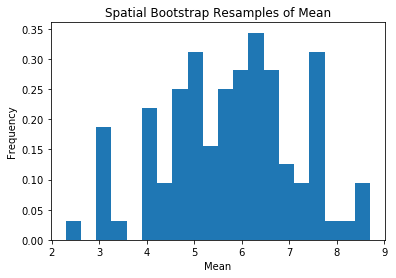

In [148]:
# 6. Visualize the summary statistic, calculate the variance or any other measure of spread to represent uncertainty in
#    the summary statistic.
plt.hist(summary,bins=20,normed=True)
plt.title("Spatial Bootstrap Resamples of Mean")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.show()

In [146]:
# 7. Summary statistics to describe uncertainty in the mean from bootstrap
columns = ['mean']
df_mean = pd.DataFrame(summary,columns=columns)
df_mean.describe()

,mean
count,100.000000
mean,5.725250
std,1.399055
min,2.300000
25%,4.700000
50%,5.875000
75%,6.675000
max,8.700000


In [ ]:
# What did we learn?
# 1. Uncertainty decreases rapidly as the number of data samples increases.
# 2. Bootstrap result for uncertainty in the mean is the same as standard error if uncorrelated and more if spatially correlated.
# 3. Spatial bootstrap provides uncertainty in any statistic.
# 4. Spatial bootstrap does account for spatial context, location of data and spatial correlation.  Resampling from realizations
#    taught by Journel is available to account for spatial trends, conditioning data, and secondary information.